In [ ]:
#dataset link

#https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression?resource=download

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv('student.csv')

x = df.drop(columns=['Performance Index'])
y = df['Performance Index']

le = LabelEncoder()
input_scaler = StandardScaler()
output_scaler = StandardScaler()

x['Extracurricular Activities'] = le.fit_transform(x['Extracurricular Activities'])

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)

X_train = input_scaler.fit_transform(X_train)
X_test = input_scaler.transform(X_test)

Y_train = output_scaler.fit_transform(np.array(Y_train).reshape(-1,1))
Y_test = output_scaler.transform(np.array(Y_test).reshape(-1,1))

In [22]:
train_set = TensorDataset(torch.tensor(X_train, dtype = torch.float32), torch.tensor(Y_train, dtype = torch.float32))
train_loader = DataLoader(train_set, batch_size = 32, shuffle = True)

test_set = TensorDataset(torch.tensor(X_test, dtype = torch.float32), torch.tensor(Y_test, dtype = torch.float32))
test_loader = DataLoader(test_set, batch_size = 32, shuffle = True)

In [31]:
class ann(nn.Module):

    def __init__(self, in_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features,10)
        self.bn1 = nn.BatchNorm1d(10)

        self.fc2 = nn.Linear(10,20)
        self.bn2 = nn.BatchNorm1d(20)

        self.fc3 = nn.Linear(20,1)

    def forward(self, X):
        out = F.relu(self.bn1(self.fc1(X)))

        out = F.relu(self.bn2(self.fc2(out)))

        return self.fc3(out)

model = ann(x.shape[1])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

n_epochs = 100
learning_rate = 0.001
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.001)

For Epoch 10: Loss = 0.041482852781191466
For Epoch 20: Loss = 0.0413249234482646
For Epoch 30: Loss = 0.03680681615322828
For Epoch 40: Loss = 0.03688003277406096
For Epoch 50: Loss = 0.03762803300656378
For Epoch 60: Loss = 0.03058139377459884
For Epoch 70: Loss = 0.03188246307335794
For Epoch 80: Loss = 0.025642951264977454
For Epoch 90: Loss = 0.029029127806425095
For Epoch 100: Loss = 0.029953445490449666


Text(0, 0.5, 'Loss')

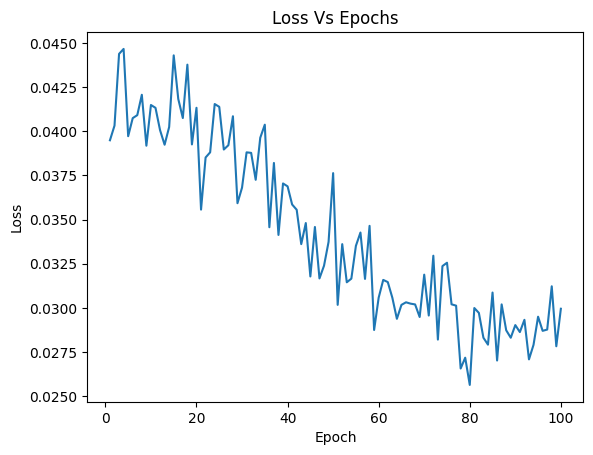

In [35]:
graph = {}

for epoch in range(n_epochs):

    total_loss = 0

    for batch_x, batch_y in train_loader:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        y_hat = model(batch_x)

        l = loss(y_hat, batch_y)

        l.backward()

        optimizer.step()

        total_loss += l.item() * batch_x.shape[0]

    if (epoch+1) % 10 == 0:

        print(f'For Epoch {epoch+1}: Loss = {total_loss / len(train_loader.dataset)}')

    graph[epoch+1] = total_loss / len(train_loader.dataset)

plt.plot(graph.keys(), graph.values())
plt.title('Loss Vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [37]:
from sklearn.metrics import r2_score, mean_absolute_error

model.eval()

y_hat = []
y_true = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        y_hat.append(model(batch_x).to('cpu'))
        y_true.append(batch_y.to('cpu'))

y_hat = torch.cat(y_hat)
y_true = torch.cat(y_true)

mae = mean_absolute_error(y_true, y_hat)
r2 = r2_score(y_true, y_hat)

print(f'MAE = {mae}, R2 = {r2}')



MAE = 0.09771495049353689, R2 = 0.9853940032042329
